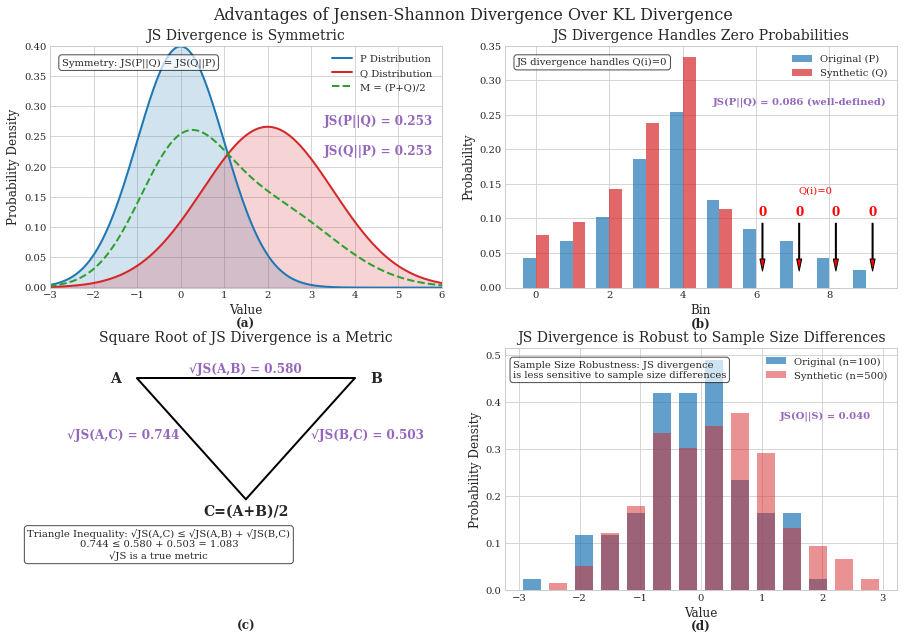

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.gridspec as gridspec

# Set clean publication style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16
})

# Create a figure with grid layout (2x2 layout)
fig = plt.figure(figsize=(14, 9), facecolor='white')  # Reduced height slightly
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], figure=fig)

# Define colors for visualizations
colors = {
    'P': '#1f77b4',  # blue
    'Q': '#d62728',  # red
    'M': '#2ca02c',  # green
    'JSD': '#9467bd',  # purple
    'KL': '#ff7f0e'   # orange
}

# JS Divergence helper function
def js_divergence(p, q):
    m = (p + q) / 2
    # Add small epsilon to avoid log(0)
    epsilon = 1e-10
    p_safe = p + epsilon
    q_safe = q + epsilon
    m_safe = m + epsilon
    
    # Normalize
    p_safe = p_safe / p_safe.sum()
    q_safe = q_safe / q_safe.sum()
    m_safe = m_safe / m_safe.sum()
    
    kl_p_m = np.sum(p_safe * np.log(p_safe / m_safe))
    kl_q_m = np.sum(q_safe * np.log(q_safe / m_safe))
    return 0.5 * kl_p_m + 0.5 * kl_q_m

# KL Divergence helper function (with safety check)
def kl_divergence(p, q):
    # Add small epsilon to avoid log(0)
    epsilon = 1e-10
    p_safe = p + epsilon
    q_safe = q + epsilon
    
    # Normalize
    p_safe = p_safe / p_safe.sum()
    q_safe = q_safe / q_safe.sum()
    
    return np.sum(p_safe * np.log(p_safe / q_safe))

# =============================================================
# 1. Top Left Panel: JSD is Symmetric (vs KL's Asymmetry)
# =============================================================
ax1 = plt.subplot(gs[0, 0])

# Create x values
x = np.linspace(-4, 8, 1000)

# Define two distributions
p_dist = stats.norm.pdf(x, 0, 1)  # Distribution P
q_dist = stats.norm.pdf(x, 2, 1.5)  # Distribution Q

# Calculate KL and JS divergences
# For continuous distributions, approximate with numerical integration
dx = x[1] - x[0]
p_discrete = p_dist * dx
q_discrete = q_dist * dx
p_discrete = p_discrete / p_discrete.sum()
q_discrete = q_discrete / q_discrete.sum()

kl_p_q = kl_divergence(p_discrete, q_discrete)
kl_q_p = kl_divergence(q_discrete, p_discrete)
js_p_q = js_divergence(p_discrete, q_discrete)
js_q_p = js_divergence(q_discrete, p_discrete)

# Plot distributions
ax1.plot(x, p_dist, '-', color=colors['P'], lw=2, label='P Distribution')
ax1.plot(x, q_dist, '-', color=colors['Q'], lw=2, label='Q Distribution')

# Shade areas for divergence visualization
ax1.fill_between(x, 0, p_dist, color=colors['P'], alpha=0.2)
ax1.fill_between(x, 0, q_dist, color=colors['Q'], alpha=0.2)

# Add M distribution
m_dist = (p_dist + q_dist) / 2
ax1.plot(x, m_dist, '--', color=colors['M'], lw=2, label='M = (P+Q)/2')

# Add JS values
ax1.text(3.3, 0.27, f"JS(P||Q) = {js_p_q:.3f}", color=colors['JSD'], fontweight='bold')
ax1.text(3.3, 0.22, f"JS(Q||P) = {js_q_p:.3f}", color=colors['JSD'], fontweight='bold')

# Add explanation box
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
ax1.text(0.03, 0.95, "Symmetry: JS(P||Q) = JS(Q||P)",
         transform=ax1.transAxes, fontsize=10, verticalalignment='top', bbox=props)

ax1.set_xlim(-3, 6)
ax1.set_ylim(0, 0.4)
ax1.set_xlabel('Value')
ax1.set_ylabel('Probability Density')
ax1.set_title('JS Divergence is Symmetric')
ax1.legend(loc='upper right')

# Add subfigure label (a)
ax1.text(0.5, -0.15, '(a)', transform=ax1.transAxes, fontsize=12, 
         ha='center', va='center', fontweight='bold')

# =============================================================
# 2. Top Right Panel: JSD is well-defined for zero probabilities
# =============================================================
ax2 = plt.subplot(gs[0, 1])

# Create histograms with some zero probabilities
bins = np.arange(10)
original = np.array([5, 8, 12, 22, 30, 15, 10, 8, 5, 3])
original_probs = original / original.sum()

# Create synthetic with zeros in some bins where original has values
synthetic_zeros = np.array([8, 10, 15, 25, 35, 12, 0, 0, 0, 0])
synthetic_zeros_probs = synthetic_zeros / synthetic_zeros.sum()

# Calculate JS Divergence and KL divergences (with safety for illustration)
js_value = js_divergence(original_probs, synthetic_zeros_probs)
kl_p_q = kl_divergence(original_probs, synthetic_zeros_probs)
kl_q_p = kl_divergence(synthetic_zeros_probs, original_probs)

# Bar width
width = 0.35

# Plot histograms
ax2.bar(bins - width/2, original_probs, width, color=colors['P'], alpha=0.7, label='Original (P)')
ax2.bar(bins + width/2, synthetic_zeros_probs, width, color=colors['Q'], alpha=0.7, label='Synthetic (Q)')

# Highlight zero probability bins
ax2.text(0.75, 0.42, f"Q(i)=0", color='red', transform=ax2.transAxes, fontsize=10, verticalalignment='top')
for i in range(len(bins)):
    if synthetic_zeros[i] == 0:
        ax2.annotate('0', xy=(bins[i]+width/2, 0.02), xytext=(bins[i]+width/2, 0.1),
                   ha='center', va='bottom', color='red', fontweight='bold',
                   arrowprops=dict(facecolor='red', shrink=0.05, width=1, headwidth=5))

# Add JS divergence value
ax2.text(0.53, 0.79, f"JS(P||Q) = {js_value:.3f} (well-defined)", transform=ax2.transAxes,
         fontsize=10, verticalalignment='top', color=colors['JSD'], fontweight='bold',
        )

# Add explanation box
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
ax2.text(0.03, 0.95, "JS divergence handles Q(i)=0",
         transform=ax2.transAxes, fontsize=10, verticalalignment='top', bbox=props)

ax2.set_xlabel('Bin')
ax2.set_ylabel('Probability')
ax2.set_title('JS Divergence Handles Zero Probabilities')
ax2.legend()

# Add subfigure label (b)
ax2.text(0.5, -0.15, '(b)', transform=ax2.transAxes, fontsize=12, 
         ha='center', va='center', fontweight='bold')

# =============================================================
# 3. Bottom Left Panel: Square root of JSD is a metric (triangle inequality)
# =============================================================
ax3 = plt.subplot(gs[1, 0])

# Create a triangle representation
triangle_x = [0, 5, 2.5]  # A, B, C x-coordinates
triangle_y = [4, 4, 0]    # A, B, C y-coordinates

# Plot triangle
ax3.plot([triangle_x[0], triangle_x[1]], [triangle_y[0], triangle_y[1]], 'k-', lw=2)  # A to B
ax3.plot([triangle_x[1], triangle_x[2]], [triangle_y[1], triangle_y[2]], 'k-', lw=2)  # B to C
ax3.plot([triangle_x[2], triangle_x[0]], [triangle_y[2], triangle_y[0]], 'k-', lw=2)  # C to A

# Add labels
ax3.text(triangle_x[0]-0.5, triangle_y[0], 'A', fontsize=14, ha='center', va='center', fontweight='bold')
ax3.text(triangle_x[1]+0.5, triangle_y[1], 'B', fontsize=14, ha='center', va='center', fontweight='bold')
ax3.text(triangle_x[2], triangle_y[2]-0.4, 'C=(A+B)/2', fontsize=14, ha='center', va='center', fontweight='bold')

# mid_point_text = ""
# ax3.text(2.5, 1, mid_point_text, fontsize=12, ha='center', va='center', fontweight='bold')

# Create three example distributions
distr_a = stats.norm.pdf(x, -1, 1)
distr_b = stats.norm.pdf(x, 1, 1)
distr_c = stats.norm.pdf(x, 3, 1.5)

# Calculate JS distances
js_a_b = js_divergence(distr_a, distr_b)
js_b_c = js_divergence(distr_b, distr_c)
js_a_c = js_divergence(distr_a, distr_c)

# Get square roots
sqrt_js_a_b = np.sqrt(js_a_b)
sqrt_js_b_c = np.sqrt(js_b_c)
sqrt_js_a_c = np.sqrt(js_a_c)

# Calculate KL distances 
kl_a_b = kl_divergence(distr_a, distr_b)
kl_b_c = kl_divergence(distr_b, distr_c)
kl_a_c = kl_divergence(distr_a, distr_c)

# Add distance annotations to edges
ax3.text(1.2, 4.2, f"√JS(A,B) = {sqrt_js_a_b:.3f}", color=colors['JSD'], fontweight='bold')
ax3.text(4, 2, f"√JS(B,C) = {sqrt_js_b_c:.3f}", color=colors['JSD'], fontweight='bold')
ax3.text(-1.6, 2, f"√JS(A,C) = {sqrt_js_a_c:.3f}", color=colors['JSD'], fontweight='bold')

# Add triangle inequality text
inequality_check = sqrt_js_a_c <= (sqrt_js_a_b + sqrt_js_b_c)
triangle_text = f"Triangle Inequality: √JS(A,C) ≤ √JS(A,B) + √JS(B,C)\n{sqrt_js_a_c:.3f} ≤ {sqrt_js_a_b:.3f} + {sqrt_js_b_c:.3f} = {sqrt_js_a_b + sqrt_js_b_c:.3f}\n"
triangle_text += "√JS is a true metric"

props = dict(boxstyle='round', facecolor='white', alpha=0.7)
ax3.text(0.5, -1.5, triangle_text, fontsize=10, ha='center', va='center', bbox=props)

# No need for KL comparison text since we're focusing just on JS divergence

ax3.set_xlim(-2, 7)
ax3.set_ylim(-3, 5)  # Reduced bottom space
ax3.set_title('Square Root of JS Divergence is a Metric')
ax3.axis('off')

# Add subfigure label (c)
ax3.text(0.5, -0.15, '(c)', transform=ax3.transAxes, fontsize=12, 
         ha='center', va='center', fontweight='bold')

# =============================================================
# 4. Bottom Right Panel: JSD is robust to sample size differences
# =============================================================
ax4 = plt.subplot(gs[1, 1])

# Create two distributions with different sample sizes
np.random.seed(42)
original_small = np.random.normal(0, 1, size=100)
synthetic_large = np.random.normal(0.2, 1.1, size=500)  # Slightly different distribution, 5x larger

# Create histogram bins
bins = np.linspace(-3, 3, 15)
original_hist, _ = np.histogram(original_small, bins=bins, density=True)
synthetic_hist, _ = np.histogram(synthetic_large, bins=bins, density=True)

# Calculate center points of bins for plotting
bin_centers = (bins[:-1] + bins[1:]) / 2

# Calculate JS and KL divergences
js_value = js_divergence(original_hist, synthetic_hist)
kl_o_s = kl_divergence(original_hist, synthetic_hist)
kl_s_o = kl_divergence(synthetic_hist, original_hist)

# Plot histograms
ax4.bar(bin_centers, original_hist, width=0.3, alpha=0.7, color=colors['P'], label='Original (n=100)')
ax4.bar(bin_centers, synthetic_hist, width=0.3, alpha=0.5, color=colors['Q'], label='Synthetic (n=500)')

# Add sample size annotations
ax4.text(0.7, 0.74, f"JS(O||S) = {js_value:.3f}", transform=ax4.transAxes,
         fontsize=10, verticalalignment='top', color=colors['JSD'], fontweight='bold',
        )

# Add explanation box
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
explanation = "Sample Size Robustness: JS divergence\n"
explanation += "is less sensitive to sample size differences"

ax4.text(0.02, 0.95, explanation, transform=ax4.transAxes, 
         fontsize=10, verticalalignment='top', bbox=props)

ax4.set_xlabel('Value')
ax4.set_ylabel('Probability Density')
ax4.set_title('JS Divergence is Robust to Sample Size Differences')
ax4.legend()

# Add subfigure label (d)
ax4.text(0.5, -0.15, '(d)', transform=ax4.transAxes, fontsize=12, 
         ha='center', va='center', fontweight='bold')

# Improve alignment and layout
plt.tight_layout(h_pad=1.5, w_pad=2.0)  # Reduced padding between subplots
fig.suptitle('Advantages of Jensen-Shannon Divergence Over KL Divergence', fontsize=16, y=0.98)
fig.subplots_adjust(top=0.92, bottom=0.08, left=0.08, right=0.92, hspace=0.25)

# Save the figure
plt.savefig('js_divergence_advantages.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\shanb\AppData\Local\Temp\ipykernel_24192\2731852813.py:164: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  ax3.plot([A[0], C[0]], [A[1], C[1]], 'k-', lw=1.5, linestyle='--')


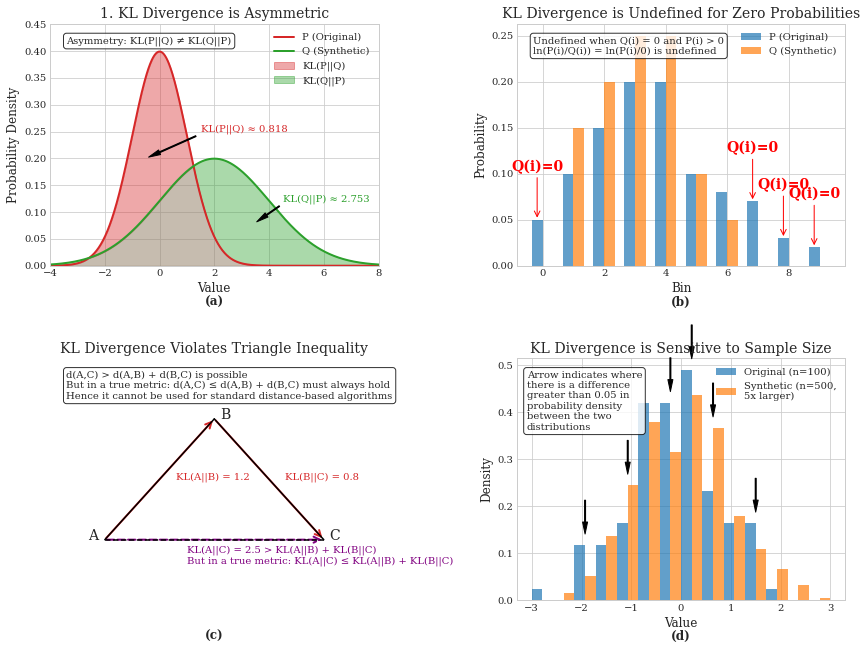

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyArrowPatch

# Set clean publication style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16
})

# Create figure with grid layout
fig = plt.figure(figsize=(12, 10), facecolor='white')
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Define colors
colors = {
    'P': '#1f77b4',  # blue
    'Q': '#ff7f0e',  # orange
    'KL_PQ': '#d62728',  # red
    'KL_QP': '#2ca02c',  # green
}

# =============================================================
# Panel 1: Asymmetry of KL Divergence
# =============================================================
ax1 = plt.subplot(gs[0, 0])

# Create data for two distributions
x = np.linspace(-6, 10, 1000)
p_dist = stats.norm.pdf(x, 0, 1)  # Distribution P
q_dist = stats.norm.pdf(x, 2, 2)  # Distribution Q (different mean and variance)

# Plot the distributions
ax1.plot(x, p_dist, '-', color='#d62728', lw=2, label='P (Original)')
ax1.plot(x, q_dist, '-', color='#2ca02c', lw=2, label='Q (Synthetic)')

# Calculate the minimum of both distributions at each point
# This represents the common area under both curves
common_area = np.minimum(p_dist, q_dist)

# Create a blended color from the P and Q distribution colors
from matplotlib.colors import to_rgb
p_rgb = to_rgb(colors['P'])  # Blue
q_rgb = to_rgb(colors['Q'])  # Orange
mixed_color = (0.5*(p_rgb[0] + q_rgb[0]), 
               0.5*(p_rgb[1] + q_rgb[1]), 
               0.5*(p_rgb[2] + q_rgb[2]))  # Mix of red and orange

# 1. First plot the common area between distributions
ax1.fill_between(x, 0, common_area, 
                 color=mixed_color, alpha=0.5)

# 2. Then plot KL(P||Q) areas (where P > Q)
ax1.fill_between(x, common_area, p_dist, 
                 where=p_dist > q_dist,
                 color=colors['KL_PQ'], alpha=0.4, label='KL(P||Q)')

# 3. Finally plot KL(Q||P) areas (where Q > P)
ax1.fill_between(x, common_area, q_dist, 
                 where=q_dist > p_dist,
                 color=colors['KL_QP'], alpha=0.4, label='KL(Q||P)')

# Calculate actual KL divergence (approximate)
def kl_divergence(p, q, dx):
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    p_safe = p + epsilon
    q_safe = q + epsilon
    
    # Calculate KL divergence
    return np.sum(p_safe * np.log(p_safe / q_safe)) * dx

dx = x[1] - x[0]
kl_pq = kl_divergence(p_dist, q_dist, dx)
kl_qp = kl_divergence(q_dist, p_dist, dx)

# Add annotations
ax1.annotate(f'KL(P||Q) ≈ {kl_pq:.3f}', xy=(-0.5, 0.20), xytext=(1.5, 0.25),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
             fontsize=10, color=colors['KL_PQ'])

ax1.annotate(f'KL(Q||P) ≈ {kl_qp:.3f}', xy=(3.5, 0.08), xytext=(4.5, 0.12),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
             fontsize=10, color=colors['KL_QP'])

# Add note about asymmetry
note = "Asymmetry: KL(P||Q) ≠ KL(Q||P)"
ax1.text(0.05, 0.95, note, transform=ax1.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax1.set_xlim(-4, 8)
ax1.set_ylim(0, 0.45)
ax1.set_xlabel('Value')
ax1.set_ylabel('Probability Density')
ax1.set_title('1. KL Divergence is Asymmetric')
ax1.legend(loc='upper right')
ax1.text(0.5, -0.15, '(a)', transform=ax1.transAxes, fontsize=12, 
        ha='center', va='center', fontweight='bold')

# =============================================================
# Panel 2: Undefined when Q(i) = 0 and P(i) > 0
# =============================================================
ax2 = plt.subplot(gs[0, 1])

# Create discrete distributions
bins = np.arange(10)
width = 0.35

# Create P with non-zero values everywhere
p_values = np.array([0.05, 0.1, 0.15, 0.2, 0.2, 0.1, 0.08, 0.07, 0.03, 0.02])

# Create Q with zero in some bins where P is non-zero
q_values = np.array([0.0, 0.15, 0.2, 0.25, 0.25, 0.1, 0.05, 0.0, 0.0, 0.0])

# Plot discrete distributions
ax2.bar(bins - width/2, p_values, width, color=colors['P'], alpha=0.7, label='P (Original)')
ax2.bar(bins + width/2, q_values, width, color=colors['Q'], alpha=0.7, label='Q (Synthetic)')

# Mark problematic areas
for i in range(len(bins)):
    if q_values[i] == 0 and p_values[i] > 0:
        ax2.annotate('Q(i)=0', xy=(bins[i] - width/2, p_values[i]), 
                     xytext=(bins[i] - width/2, p_values[i] + 0.05),
                     fontsize=14, color='red', weight='bold',
                     ha='center', va='bottom',
                     arrowprops=dict(arrowstyle="->", color='red'))
        
# Add explanation
note = "Undefined when Q(i) = 0 and P(i) > 0\nln(P(i)/Q(i)) = ln(P(i)/0) is undefined"
ax2.text(0.05, 0.95, note, transform=ax2.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2.set_xlabel('Bin')
ax2.set_ylabel('Probability')
ax2.set_title('KL Divergence is Undefined for Zero Probabilities')
ax2.text(0.5, -0.15, '(b)', transform=ax2.transAxes, fontsize=12, 
        ha='center', va='center', fontweight='bold')
ax2.legend()

# =============================================================
# Panel 3: Not a true metric (triangle inequality)
# =============================================================
ax3 = plt.subplot(gs[1, 0])

# Create a visualization of the triangle inequality
# Create a triangle shape to show the violation
# Set up coordinates for points
A = np.array([1, 1])  # Distribution A
B = np.array([3, 3])  # Distribution B 
C = np.array([5, 1])  # Distribution C

# Draw the triangle
ax3.plot([A[0], B[0]], [A[1], B[1]], 'k-', lw=1.5)
ax3.plot([B[0], C[0]], [B[1], C[1]], 'k-', lw=1.5)
ax3.plot([A[0], C[0]], [A[1], C[1]], 'k-', lw=1.5, linestyle='--')

# Add arrows to represent directed KL divergence
arrow_kl_ab = FancyArrowPatch(A, B, arrowstyle='->', mutation_scale=15, 
                            color=colors['KL_PQ'], linewidth=2, label='KL(A||B)')
arrow_kl_bc = FancyArrowPatch(B, C, arrowstyle='->', mutation_scale=15, 
                            color=colors['KL_PQ'], linewidth=2, label='KL(B||C)')
arrow_kl_ac = FancyArrowPatch(A, C, arrowstyle='->', mutation_scale=15, 
                            color='purple', linewidth=2, linestyle='--', label='KL(A||C)')

ax3.add_patch(arrow_kl_ab)
ax3.add_patch(arrow_kl_bc)
ax3.add_patch(arrow_kl_ac)

# Label the points
ax3.text(A[0]-0.3, A[1], 'A', fontsize=14)
ax3.text(B[0]+0.1, B[1], 'B', fontsize=14)
ax3.text(C[0]+0.1, C[1], 'C', fontsize=14)

# Add value labels for the divergences
ax3.text((A[0]+B[0])/2 + 0.3, (A[1]+B[1])/2, 'KL(A||B) = 1.2', 
         color=colors['KL_PQ'], fontsize=10)
ax3.text((B[0]+C[0])/2 + 0.3, (B[1]+C[1])/2, 'KL(B||C) = 0.8', 
         color=colors['KL_PQ'], fontsize=10)
ax3.text((A[0]+C[0])/2 - 0.5, (A[1]+C[1])/2 - 0.4, 'KL(A||C) = 2.5 > KL(A||B) + KL(B||C)\nBut in a true metric: KL(A||C) ≤ KL(A||B) + KL(B||C)', 
         color='purple', fontsize=10)

# Add explanation
note = "d(A,C) > d(A,B) + d(B,C) is possible\nBut in a true metric: d(A,C) ≤ d(A,B) + d(B,C) must always hold\nHence it cannot be used for standard distance-based algorithms"
ax3.text(0.05, 0.95, note, transform=ax3.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3.set_xlim(0, 6)
ax3.set_ylim(0, 4)
ax3.set_title('KL Divergence Violates Triangle Inequality')
ax3.text(0.5, -0.15, '(c)', transform=ax3.transAxes, fontsize=12, 
        ha='center', va='center', fontweight='bold')
ax3.axis('off')

# =============================================================
# Panel 4: Sample size sensitivity
# =============================================================
ax4 = plt.subplot(gs[1, 1])

# Create histogram data for two samples of different sizes
np.random.seed(42)
small_sample = np.random.normal(0, 1, size=100)
large_sample = np.random.normal(0, 1, size=500)  # 5x larger, same distribution

# Calculate histogram information
bins_array = np.linspace(-3, 3, 15)

# Plot original histograms
small_hist, _ = np.histogram(small_sample, bins=bins_array, density=True)
large_hist, _ = np.histogram(large_sample, bins=bins_array, density=True)

# Plot centers of bins
bin_centers = (bins_array[:-1] + bins_array[1:]) / 2
width = bins_array[1] - bins_array[0]

# Plot the histograms as bars
ax4.bar(bin_centers - width/4, small_hist, width=width/2, alpha=0.7, color=colors['P'], 
       label='Original (n=100)')
ax4.bar(bin_centers + width/4, large_hist, width=width/2, alpha=0.7, color=colors['Q'], 
       label='Synthetic (n=500,\n5x larger)')

# Calculate KL divergence
kl_small_large = kl_divergence(small_hist, large_hist, width)
kl_large_small = kl_divergence(large_hist, small_hist, width)

# Add annotation arrows pointing to discrepancies
for i in range(len(bin_centers)):
    if abs(small_hist[i] - large_hist[i]) > 0.05:
        ax4.annotate('', xy=(bin_centers[i], max(small_hist[i], large_hist[i]) + 0.02),
                    xytext=(bin_centers[i], max(small_hist[i], large_hist[i]) + 0.1),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))

# Add explanation
note = (
    "Arrow indicates where\n"
    "there is a difference\n"
    "greater than 0.05 in \n"
    "probability density\n"
    "between the two\n"
    "distributions"
).format(kl_small_large, kl_large_small)

ax4.text(0.03, 0.95, note, transform=ax4.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax4.set_xlabel('Value')
ax4.set_ylabel('Density')
ax4.set_title('KL Divergence is Sensitive to Sample Size')
ax4.text(0.5, -0.15, '(d)', transform=ax4.transAxes, fontsize=12, 
        ha='center', va='center', fontweight='bold')
ax4.legend(loc='upper right')

# Adjust layout
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the figure
plt.savefig('kl_divergence_limitations.png', dpi=300, bbox_inches='tight')
plt.show()

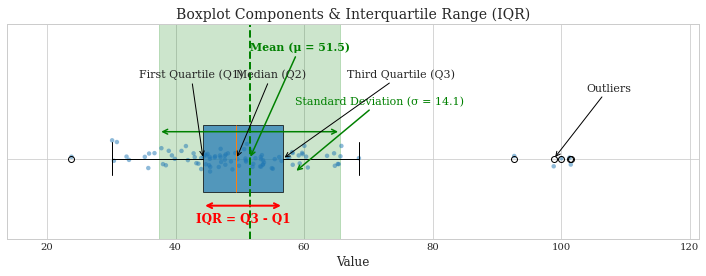

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Set the style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16
})

# Create a figure
fig, ax = plt.subplots(figsize=(10, 5))

# Create synthetic data with a clear distribution and outliers
np.random.seed(42)
data = np.concatenate([
    np.random.normal(loc=50, scale=10, size=95),  # Main distribution
    np.random.normal(loc=100, scale=5, size=5)    # Outliers
])

# Calculate mean and standard deviation
mean_val = np.mean(data)
std_val = np.std(data)

# Create horizontal boxplot
box_elements = ax.boxplot(data, patch_artist=True, widths=0.5, vert=False)
box_elements['boxes'][0].set_facecolor('#1f77b4')
box_elements['boxes'][0].set_alpha(0.7)

# Add mean line in a distinct color
ax.axvline(x=mean_val, color='green', linestyle='--', linewidth=2)

# Plot standard deviation range
ax.axvspan(mean_val - std_val, mean_val + std_val, alpha=0.2, color='green')

# Scatter individual points with jitter
y = np.random.normal(1, 0.05, size=len(data))
ax.scatter(data, y, alpha=0.5, s=20, color='#1f77b4', edgecolor='none')

# Calculate quartiles for annotation
q1 = np.percentile(data, 25)
q2 = np.percentile(data, 50)  # median
q3 = np.percentile(data, 75)
iqr = q3 - q1

# Add annotations for mean and standard deviation
ax.annotate(f'Mean (μ = {mean_val:.1f})', xy=(mean_val, 1), xytext=(mean_val, 1.8),
             arrowprops=dict(arrowstyle='->', color='green', linewidth=1.5), 
             fontsize=11, color='green', fontweight='bold')

ax.annotate(f'Standard Deviation (σ = {std_val:.1f})', 
             xy=(mean_val + std_val/2, 0.9), 
             xytext=(mean_val + std_val/2, 1.4),
             arrowprops=dict(arrowstyle='->', color='green', linewidth=1.5), 
             fontsize=11, color='green')

# Add double-headed arrow for standard deviation range
ax.annotate('', xy=(mean_val - std_val, 1.2), xytext=(mean_val + std_val, 1.2),
            arrowprops=dict(arrowstyle='<->', color='green', linewidth=1.5))

# Add annotations for the parts of the boxplot
# Median line
ax.annotate('Median (Q2)', xy=(q2, 1), xytext=(q2, 1.6),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=11)

# Q1 annotation
ax.annotate('First Quartile (Q1)', xy=(q1, 1), xytext=(q1-10, 1.6),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=11)

# Q3 annotation
ax.annotate('Third Quartile (Q3)', xy=(q3, 1), xytext=(q3+10, 1.6),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=11)

# IQR annotation with arrow - positioned below the boxplot
ax.annotate('', xy=(q1, 0.65), xytext=(q3, 0.65),
            arrowprops=dict(arrowstyle='<->', color='red', lw=2))
ax.text((q1+q3)/2, 0.55, 'IQR = Q3 - Q1', color='red', fontsize=12, 
        fontweight='bold', ha='center', va='center')

# Adjust the outliers annotation position
outliers = data[data > q3 + 1.5*iqr]
if len(outliers) > 0:
    ax.annotate('Outliers', xy=(outliers.mean(), 1), xytext=(outliers.mean()+5, 1.5),
                 arrowprops=dict(arrowstyle='->', color='black'), fontsize=11)

# Add title and remove y-axis labels
ax.set_title('Boxplot Components & Interquartile Range (IQR)', fontsize=14)
ax.set_xlabel('Value', fontsize=12)
ax.set_yticklabels([''])

# Set appropriate x and y limits
x_min = min(data) - 10
x_max = max(data) + 20
ax.set_xlim(x_min, x_max)
ax.set_ylim(0.4, 2.0)

plt.tight_layout(rect=[0, 0.15, 1, 0.95])
plt.savefig('iqr_boxplot_visualization.png', dpi=300, bbox_inches='tight')
plt.show()